## Dataset Generator: *single_band_LSSTgenerator.py*

This script generates a dataset of **mock gravitational lensing images** simulating the observational conditions of the **LSST (g-band)** for studying the detectability of **dark matter subhalos**.  
Each entry in the dataset consists of a *pair of images* — one with and one without a subhalo perturbation — along with derived physical quantities such as the lensing potential difference and the chi-squared metrics.

---

###  **Cosmological and lens model setup**
- Cosmology: flat ΛCDM with $ H_0 = 70\,\mathrm{km\,s^{-1}\,Mpc^{-1}} $, $ \Omega_m = 0.3 $.
- Lens redshift $ z_l = 0.881 $, source redshift $ z_s = 2.059 $.
- The main lens is modeled as an **Elliptical Power-Law (EPL)** profile plus **external shear**.
- Subhalos follow a **Singular Isothermal Sphere (SIS)** model, randomly placed within ±1.6″ of the lens center.
- Sources are **Sérsic ellipses** with random positions within ±1.0″.

---

###  **Image simulation details**
- Observing band: LSST *g*-band using the 10-year coadd configuration.
- Field of view: $6\text{ arcsec} \times 6\text{ arcsec}$, pixel scale ≈ 0.04″.
- Each realization generates:
  1. `image_sub` — lensed image including the subhalo, with realistic noise.  
  2. `image_nosub_nonoise` — corresponding image *without* the subhalo and *without noise*.  
  3. `delta_psi` — 2D map of the lensing potential difference:
     $$
     \Delta\psi = \psi_\mathrm{sub} - \psi_\mathrm{nosub}
     $$
- Instrumental noise is added following the LSST noise model provided by `lenstronomy.SimulationAPI`.

---

###  **Derived physical quantities**
For each image pair, two statistical measures are computed:
$$
\xi^2 = \sum_i \frac{(I_\text{sub}(i) - I_\text{nosub}(i))^2}{\sigma(i)^2}
$$
$$
\xi^2_\text{red} = \frac{\xi^2}{N_\text{dof}}
$$
where $ \sigma(i) $ is the per-pixel noise estimated from `SimAPI.estimate_noise()`.  
The reduced chi-squared $ \xi^2_\text{red} $ quantifies the *detectability* of the subhalo-induced perturbation in the lensed image.

---

###  **Output structure**
The dataset is stored as an **HDF5 file** (`LSST_singleband_dataset.h5`), with the following fields:

| Dataset key | Description | Shape |
|--------------|-------------|--------|
| `image_sub` | Noisy image with subhalo | (N, H, W) |
| `image_nosub_nonoise` | Noise-free image without subhalo | (N, H, W) |
| `delta_psi` | Potential difference map | (N, H, W) |
| `xi2`, `xi2_reduced` | Global and reduced χ² statistics | (N,) |
| `subhalo_mass` | Subhalo mass (M⊙) | (N,) |
| `subhalo_x`, `subhalo_y` | Subhalo position (arcsec) | (N,) |
| `source_x`, `source_y` | Source position (arcsec) | (N,) |

Additionally, file-level attributes record cosmology, pixel scale, mass and position ranges, and the χ² definition used.

---

### **Usage summary**
Running the generator produces `N_TOTAL` realizations (default: 10,000), printing progress and sample χ² values every 50 iterations.  
This dataset serves as the training foundation for machine-learning experiments aiming to **predict or classify subhalo detectability** based on the lensed image properties.


---

Now we can explore the dataset

## 🔍 Single-band Dataset Explorer and Diagnostics

This notebook cell provides a **visual and statistical exploration tool** for the single-band LSST lensing dataset (`LSST_singleband_dataset.h5`).  
It allows visual inspection of random simulated examples and diagnostic plots to understand the overall distribution and correlations among key quantities.

---

### **Purpose**
The goal of this diagnostic script is to:
- Visually inspect a few random **image pairs** (with and without subhalo).  
- Compare **residuals** and **potential maps (Δψ)** between the two cases.  
- Explore the distributions of:
  - Total chi-squared (ξ²)
  - Reduced chi-squared (ξ²<sub>red</sub>)
  - Global signal-to-noise ratio (SNR = √ξ²)
  - Subhalo mass–signal correlation

---

###  **Displayed panels for each random example**
For a random subset of N examples (default = 4), each row in the figure shows:

| Panel | Description |
|:------|:-------------|
| (1) Observed | Image including the subhalo and realistic noise. |
| (2) Clean | Baseline image without subhalo and without noise. |
| (3) Residual | Absolute pixel-wise difference $$|I_\text{obs} - I_\text{clean}|$. |
| (4) Δψ map | Difference in lensing potential between the two lens models. |
| (5) Metrics | Numeric values of ξ², ξ²<sub>red</sub>, SNR, and coordinates of the subhalo and source. |

Subhalo and source positions are marked with **“×”** and **“+”** symbols, respectively.

---

###  **Global diagnostic plots**
Below the visual examples, the script also generates several statistical plots:
1. **Distribution of log₁₀(ξ²)** — overall chi-squared distribution.  
2. **Distribution of reduced ξ²** — diagnostic for model quality / detectability.  
3. **Distribution of SNR = √ξ²** — overall signal-to-noise proxy.  
4. **Mass–signal correlation** — scatter plot of log₁₀(M<sub>sub</sub>) vs log₁₀(ξ²<sub>red</sub>) including Spearman rank correlation.

---

###  **Quick summary statistics**
At the end of execution, the script prints global summary metrics:
- Sample size `N`
- Median and percentile ranges (p16–p84) of reduced ξ²  
- Median and percentile ranges of SNR

---

###  **Interpretation**
- Higher ξ²<sub>red</sub> or SNR values correspond to **more detectable subhalos**.  
- The mass–signal correlation helps assess the detectability threshold as a function of subhalo mass.  
- Residual maps indicate **where in the image** the perturbation from the subhalo dominates.


Random examples: [8599, 154, 6074, 7625]


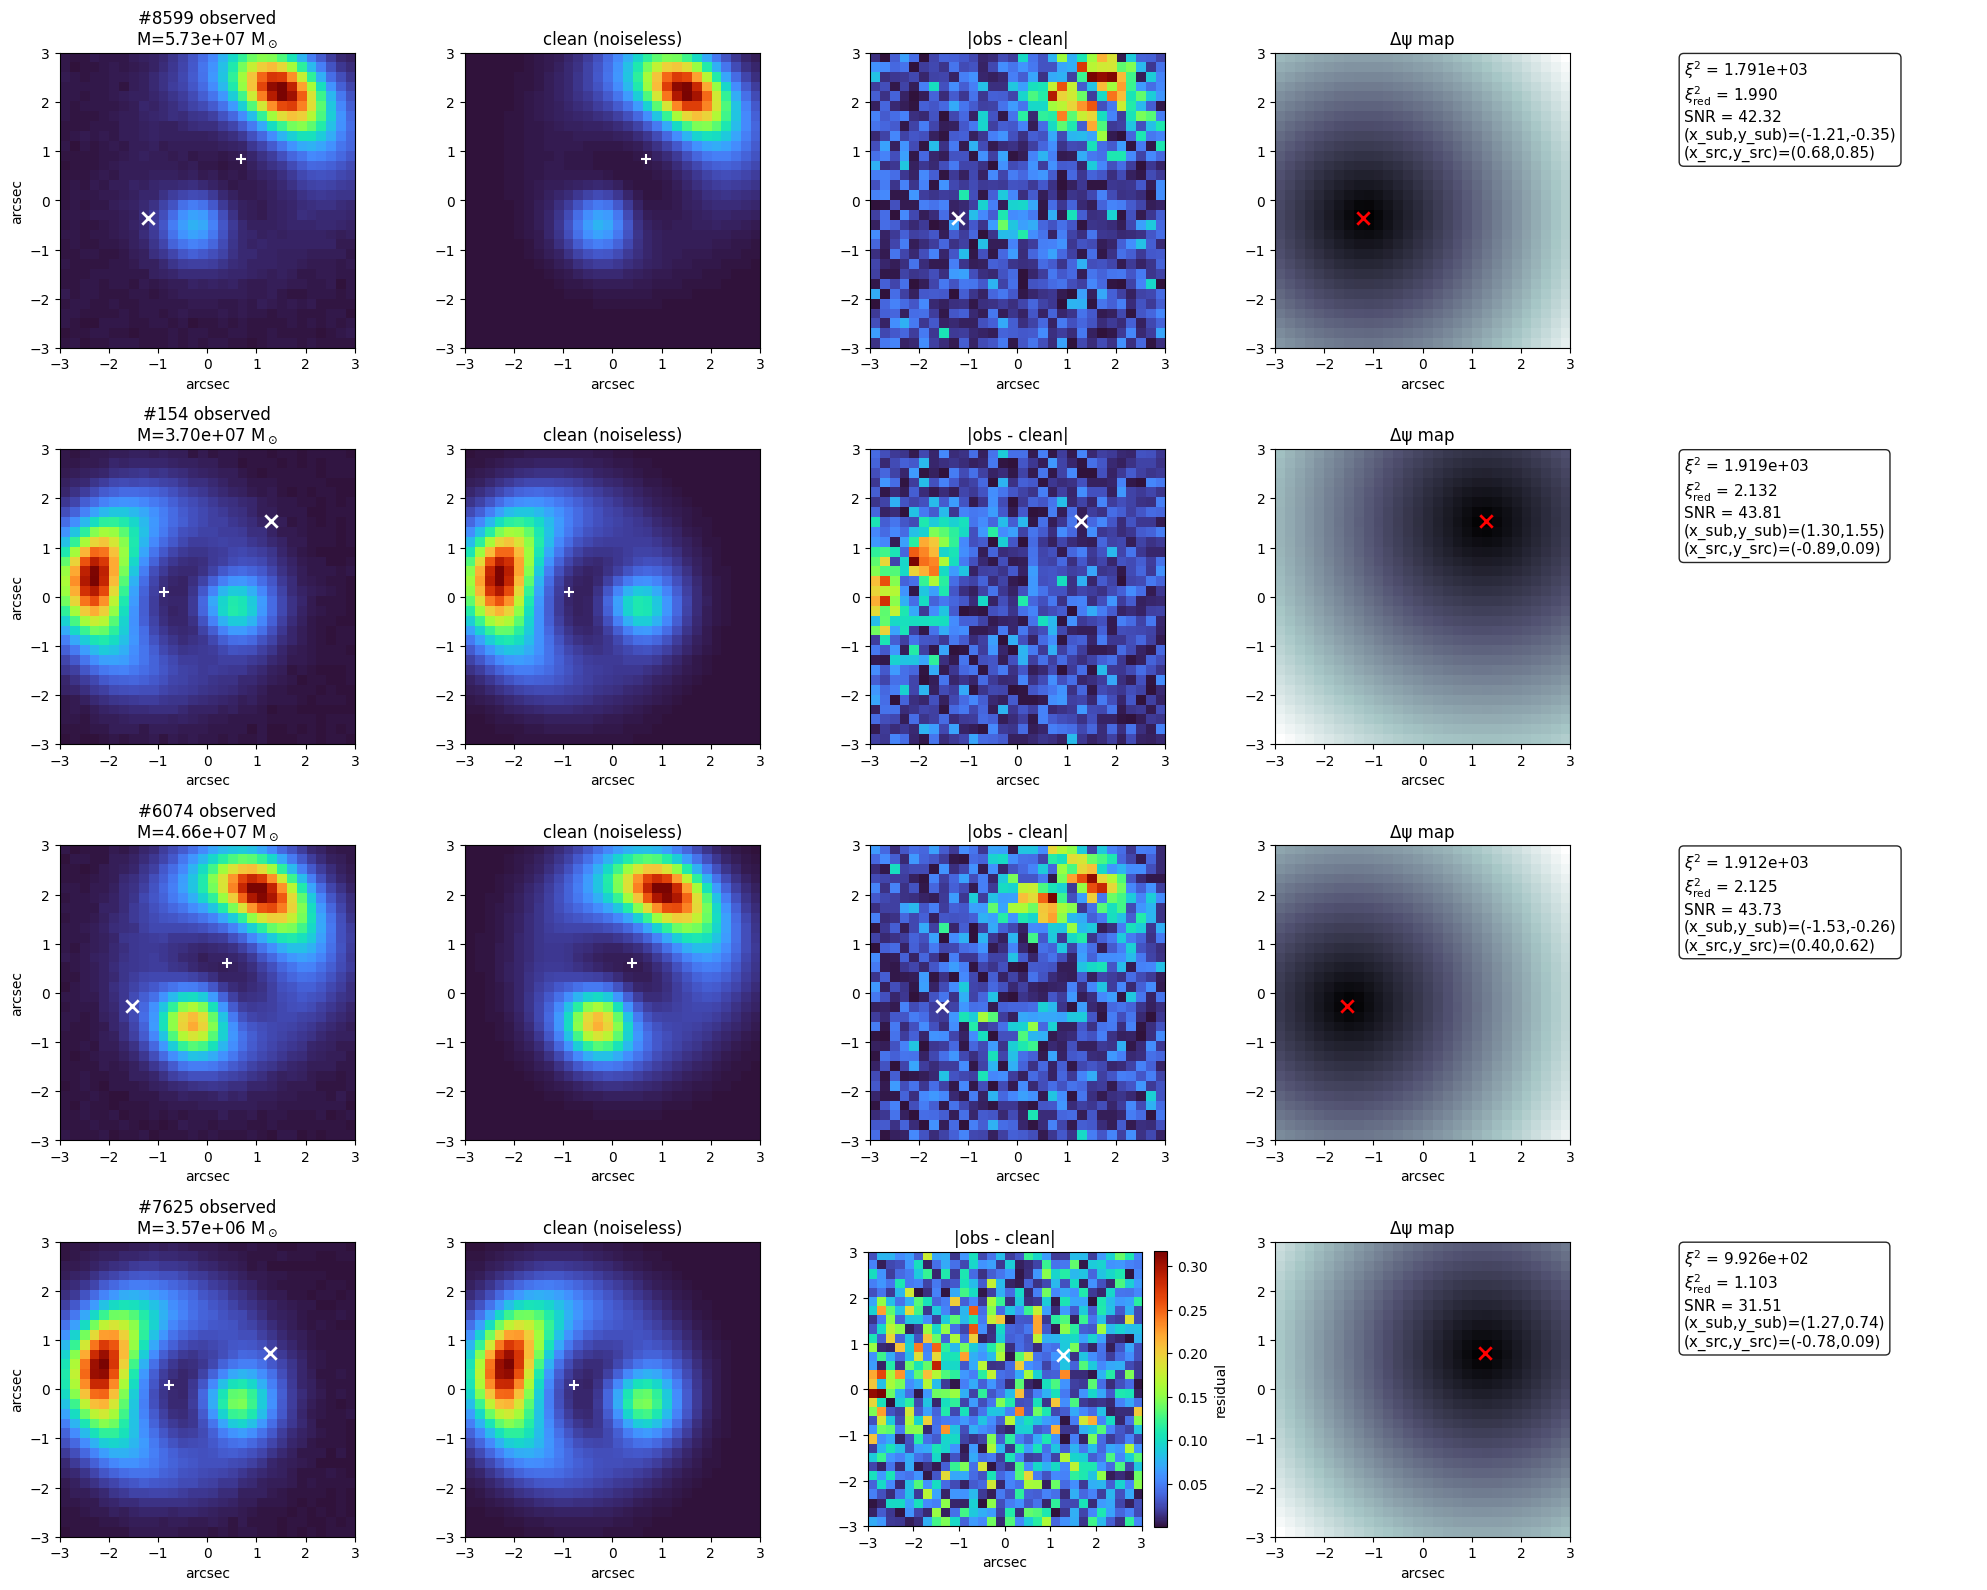

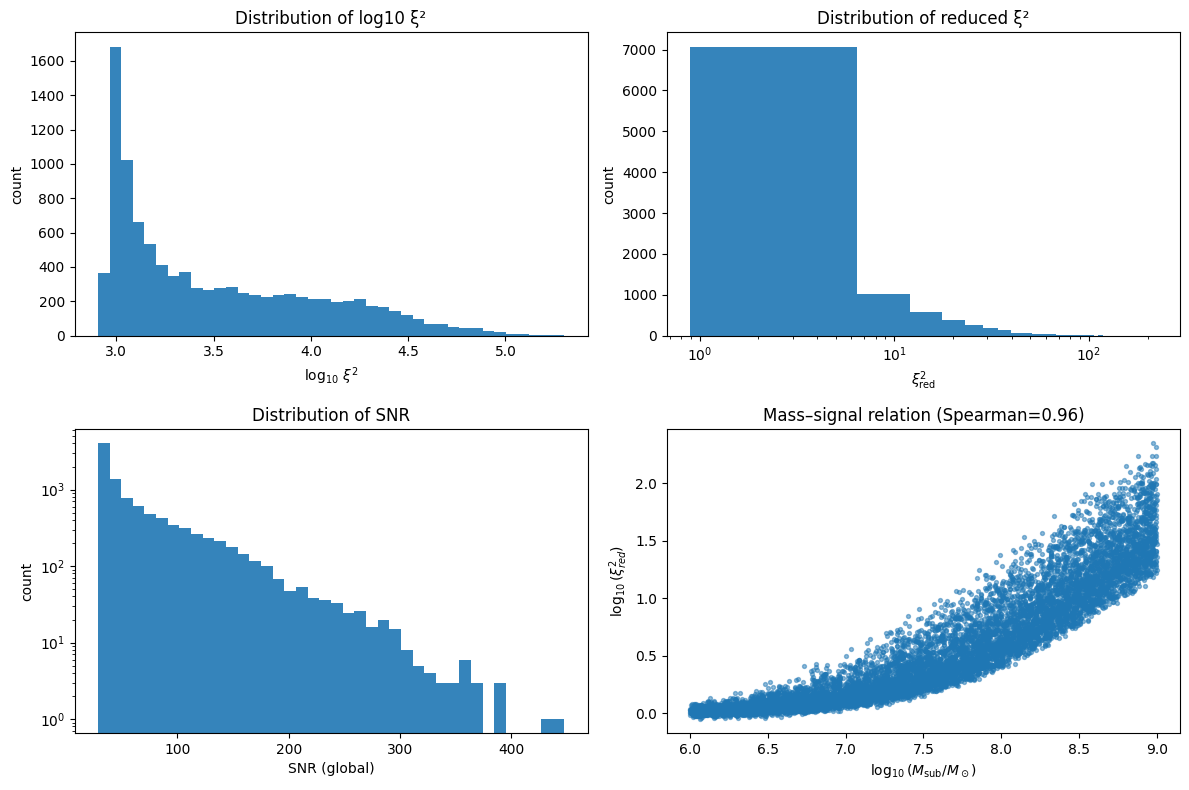

N=10000
reduced ξ²: median=2.331, p16=1.130, p84=14.626
SNR: median=45.80, p16=31.89, p84=114.73


In [1]:
# explore_singleband_h5 — random sampler + diagnostics (NO mask; residual computed here)
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# ======================
# Parameters
# ======================
h5_path = 'LSST_singleband_dataset.h5'  # <-- adjust if you renamed your output file
N_EXAMPLES = 4
RANDOM_SEED = None

# -----------------------------
# Helper functions
# -----------------------------
def _pick_attr(attrs, name, default=None, cast=float):
    """Safely extract an attribute and cast it to the desired type."""
    try:
        return cast(attrs[name])
    except Exception:
        return default

def _extent_from_attrs(f, shape_hw=None):
    """Infer the extent (arcsec) of an image from stored metadata."""
    if 'stamp_size_arcsec' in f.attrs:
        L = float(f.attrs['stamp_size_arcsec'])
        return [-L/2, L/2, -L/2, L/2]
    if shape_hw is None:
        return [-3, 3, -3, 3]
    H, W = shape_hw
    ps = _pick_attr(f.attrs, 'pixel_scale', 0.15)  # stored in the generator as 'pixel_scale'
    return [-W*ps/2, W*ps/2, -H*ps/2, H*ps/2]

def _safe_log10(x, lo=1e-30, hi=1e300):
    """Numerically safe log10 transformation with clipping."""
    x = np.asarray(x, float)
    return np.log10(np.clip(x, lo, hi))

# -----------------------------
# Visualization
# -----------------------------
with h5py.File(h5_path, 'r') as f:
    # Expected dataset keys for single-band version
    k_obs   = 'image_sub'             # (N,H,W) with subhalo + noise (linear)
    k_clean = 'image_nosub_nonoise'   # (N,H,W) without subhalo + no noise (linear)
    k_dpsi  = 'delta_psi'             # (N,H,W)

    # Scalar datasets
    xi2   = f['xi2'][:]         if 'xi2'         in f else None
    xi2r  = f['xi2_reduced'][:] if 'xi2_reduced' in f else None
    mass  = f['subhalo_mass'][:] if 'subhalo_mass' in f else None
    x_sub = f['subhalo_x'][:]     if 'subhalo_x'     in f else None
    y_sub = f['subhalo_y'][:]     if 'subhalo_y'     in f else None
    x_src = f['source_x'][:]      if 'source_x'      in f else None
    y_src = f['source_y'][:]      if 'source_y'      in f else None

    X = f[k_obs]
    N, H, W = X.shape
    extent = _extent_from_attrs(f, (H, W))

    # Global SNR proxy consistent with xi2: SNR = sqrt(sum ΔI²/σ²) ≡ sqrt(xi2)
    snr = np.sqrt(np.clip(xi2, 0, None)) if xi2 is not None else None

    # Random examples
    rng = np.random.default_rng(RANDOM_SEED) if RANDOM_SEED is not None else np.random.default_rng()
    n_examples = min(N_EXAMPLES, N)
    idxs = rng.choice(np.arange(N), size=n_examples, replace=False)
    print("Random examples:", idxs.tolist())

    # Figure: observed | clean | residual | Δψ | metrics
    ncols = 5
    fig, axes = plt.subplots(len(idxs), ncols, figsize=(4*ncols, 4*len(idxs)))
    if len(idxs) == 1:
        axes = np.expand_dims(axes, 0)

    for row, idx in enumerate(idxs):
        m  = mass[idx]  if mass is not None else np.nan
        xs = x_sub[idx] if x_sub is not None else np.nan
        ys = y_sub[idx] if y_sub is not None else np.nan
        x0 = x_src[idx] if x_src is not None else np.nan
        y0 = y_src[idx] if y_src is not None else np.nan

        # (1) Observed image (with noise)
        ax = axes[row, 0]
        obs = f[k_obs][idx]
        im0 = ax.imshow(obs, origin='lower', extent=extent, cmap='turbo', interpolation='nearest')
        if np.isfinite(xs) and np.isfinite(ys): ax.scatter([xs],[ys], s=80, marker='x', lw=2, c='w')
        if np.isfinite(x0) and np.isfinite(y0): ax.scatter([x0],[y0], s=60, marker='+', lw=1.5, c='w')
        ax.set_title(f"#{idx} observed\nM={m:.2e} M$_\\odot$")
        ax.set_xlabel("arcsec"); ax.set_ylabel("arcsec")

        # (2) Clean (noiseless baseline)
        ax = axes[row, 1]
        clean = f[k_clean][idx]
        ax.imshow(clean, origin='lower', extent=extent, cmap='turbo', interpolation='nearest')
        if np.isfinite(x0) and np.isfinite(y0): ax.scatter([x0],[y0], s=60, marker='+', lw=1.5, c='w')
        ax.set_title("clean (noiseless)")
        ax.set_xlabel("arcsec")

        # (3) Residual |obs - clean|
        ax = axes[row, 2]
        resid = abs(obs - clean)
        im = ax.imshow(resid, origin='lower', extent=extent, cmap='turbo', interpolation='nearest')
        if np.isfinite(xs) and np.isfinite(ys): ax.scatter([xs],[ys], s=80, marker='x', lw=2, c='w')
        ax.set_title(r"|obs - clean|")
        ax.set_xlabel("arcsec")
        if row == len(idxs)-1:
            cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            cbar.ax.set_ylabel("residual")

        # (4) Δψ
        ax = axes[row, 3]
        ax.imshow(f[k_dpsi][idx], origin='lower', extent=extent, cmap='bone', interpolation='nearest')
        if np.isfinite(xs) and np.isfinite(ys): ax.scatter([xs],[ys], s=80, marker='x', lw=2, c='r')
        ax.set_title("Δψ map")
        ax.set_xlabel("arcsec")

        # (5) Metrics panel (text)
        ax = axes[row, 4]
        ax.axis('off')
        lines = []
        if xi2 is not None:  lines.append(r"$\xi^2$ = %.3e" % xi2[idx])
        if xi2r is not None: lines.append(r"$\xi^2_{\rm red}$ = %.3f" % xi2r[idx])
        if snr is not None:  lines.append(r"SNR = %.2f" % snr[idx])
        lines.append(f"(x_sub,y_sub)=({xs:.2f},{ys:.2f})")
        lines.append(f"(x_src,y_src)=({x0:.2f},{y0:.2f})")
        ax.text(0.02, 0.98, "\n".join(lines), transform=ax.transAxes,
                va='top', ha='left', fontsize=11,
                bbox=dict(boxstyle='round', fc='white', alpha=.85))

    plt.tight_layout(); plt.show()

    # ===========================================
    # 2) DIAGNOSTICS (subplots)
    # ===========================================
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    ax11, ax12 = axs[0]
    ax21, ax22 = axs[1]

    # (1,1) Distribution of log10(ξ²)
    if xi2 is not None:
        xi2_log = _safe_log10(xi2)
        ax11.hist(xi2_log[np.isfinite(xi2_log)], bins=40, alpha=.9)
        ax11.set_xlabel(r'$\log_{10}\,\xi^2$'); ax11.set_ylabel("count")
        ax11.set_title("Distribution of log10 ξ²")
    else:
        ax11.axis('off'); ax11.set_title("ξ² not available")

    # (1,2) Distribution of ξ²_red (linear scale)
    if xi2r is not None:
        val = xi2r[np.isfinite(xi2r)]
        ax12.hist(val, bins=40, alpha=.9)
        ax12.set_xscale('log')
        ax12.set_xlabel(r'$\xi^2_{\rm red}$'); ax12.set_ylabel("count")
        ax12.set_title("Distribution of reduced ξ²")
    else:
        ax12.axis('off'); ax12.set_title("ξ²_red not available")

    # (2,1) Distribution of SNR (= sqrt ξ²)
    if snr is not None:
        ax21.hist(snr[np.isfinite(snr)], bins=40, alpha=.9)
        ax21.set_yscale('log')
        ax21.set_xlabel("SNR (global)"); ax21.set_ylabel("count")
        ax21.set_title("Distribution of SNR")
    else:
        ax21.axis('off'); ax21.set_title("SNR not available")

    # (2,2) Mass–signal relation: log M vs log ξ²_red
    if (mass is not None) and (xi2 is not None):
        logM = np.log10(np.clip(mass, 1e-30, None))
        logX = _safe_log10(xi2r)
        msk = np.isfinite(logM) & np.isfinite(logX)
        ax22.scatter(logM[msk], logX[msk], s=8, alpha=.5)
        rho, _ = spearmanr(logM[msk], logX[msk]) if msk.any() else (np.nan, np.nan)
        ax22.set_xlabel(r'$\log_{10}(M_{\rm sub}/M_\odot)$')
        ax22.set_ylabel(r'$\log_{10}(\xi_{red}^2)$')
        ax22.set_title(f'Mass–signal relation (Spearman={rho:.2f})')
    else:
        ax22.axis('off'); ax22.set_title("Mass relation not available")

    plt.tight_layout(); plt.show()

    # Quick summary
    print(f"N={N}")
    if xi2r is not None:
        print("reduced ξ²: median=%.3f, p16=%.3f, p84=%.3f" %
              (np.nanmedian(xi2r), np.nanpercentile(xi2r, 16), np.nanpercentile(xi2r, 84)))
    if snr is not None:
        print("SNR: median=%.2f, p16=%.2f, p84=%.2f" %
              (np.nanmedian(snr), np.nanpercentile(snr, 16), np.nanpercentile(snr, 84)))


## Geometrical and Physical Distributions vs. Reduced χ² (ξ²<sub>red</sub>)

This analysis cell explores how the **geometrical configuration** of the lensing system and the **subhalo properties** relate to the reduced chi-squared signal (ξ²<sub>red</sub>).  
It helps identify which spatial configurations make a subhalo more *detectable* in the simulated LSST single-band dataset.

---

###  **Quantities analyzed**
For each simulation entry, the following quantities are extracted from the dataset:

| Symbol | Description | Unit |
|:--------|:-------------|:------|
| M<sub>sub</sub> | Subhalo mass | M⊙ |
| (x<sub>sub</sub>, y<sub>sub</sub>) | Subhalo position | arcsec |
| (x<sub>src</sub>, y<sub>src</sub>) | Source position | arcsec |
| (x<sub>lens</sub>, y<sub>lens</sub>) | Lens center | arcsec |
| ξ²<sub>red</sub> | Reduced chi-squared statistic | dimensionless |

Using these, the script computes three characteristic distances:
$$
d_{\text{sub,src}} = \sqrt{(x_\text{sub}-x_\text{src})^2 + (y_\text{sub}-y_\text{src})^2}
$$
$$
d_{\text{sub,lens}} = \sqrt{(x_\text{sub}-x_\text{lens})^2 + (y_\text{sub}-y_\text{lens})^2}
$$
$$
d_{\text{src,lens}} = \sqrt{(x_\text{src}-x_\text{lens})^2 + (y_\text{src}-y_\text{lens})^2}
$$

---

### **Figure 1 — Mass and positional distributions**

| Subplot | Description |
|:--------|:-------------|
| (1,1) | Histogram of log₁₀(M<sub>sub</sub>) showing the sampled mass range. |
| (1,2) | 2D hexbin map of subhalo spatial positions (x<sub>sub</sub>, y<sub>sub</sub>) within the image. |
| (2,1) | Scatter plot of ξ²<sub>red</sub> vs. d<sub>sub,src</sub> (distance between subhalo and source). |
| (2,2) | Scatter plot of ξ²<sub>red</sub> vs. d<sub>sub,lens</sub> (distance between subhalo and lens center). |

Each scatter plot includes a **Spearman correlation coefficient (ρ)** to quantify the monotonic relationship between geometry and detectability.

---

### **Figure 2 — 2D geometry plane colored by ξ²<sub>red</sub>**
This panel shows the **(d<sub>sub,src</sub>, d<sub>sub,lens</sub>)** plane, color-coded by log₁₀(ξ²<sub>red</sub>).  
It provides a direct visualization of how detectability depends jointly on the subhalo’s proximity to both the source and the main lens.

---

### **Figure 3 — ξ²<sub>red</sub> vs. d<sub>src,lens</sub>**
A complementary diagnostic showing the relation between the **source–lens separation** and ξ²<sub>red</sub>.  
This can reveal whether certain alignments (e.g., nearly overlapping source–lens positions) lead to stronger subhalo signatures.

---

### **Interpretation**
- Higher ξ²<sub>red</sub> typically occurs when the **subhalo lies near the Einstein ring** or close to the **brightest source features**.  
- The correlation between ξ²<sub>red</sub> and the distances d<sub>sub,src</sub> and d<sub>sub,lens</sub> reflects how **lensing geometry governs detectability**.  
- The mass distribution and its correlation with ξ²<sub>red</sub> provide insight into **mass sensitivity limits** of the simulated observations.

---

### **Takeaway**
This diagnostic complements the pixel-based visual explorer by providing **global statistical insights** into how subhalo mass and spatial configuration drive measurable deviations in the observed image signal.


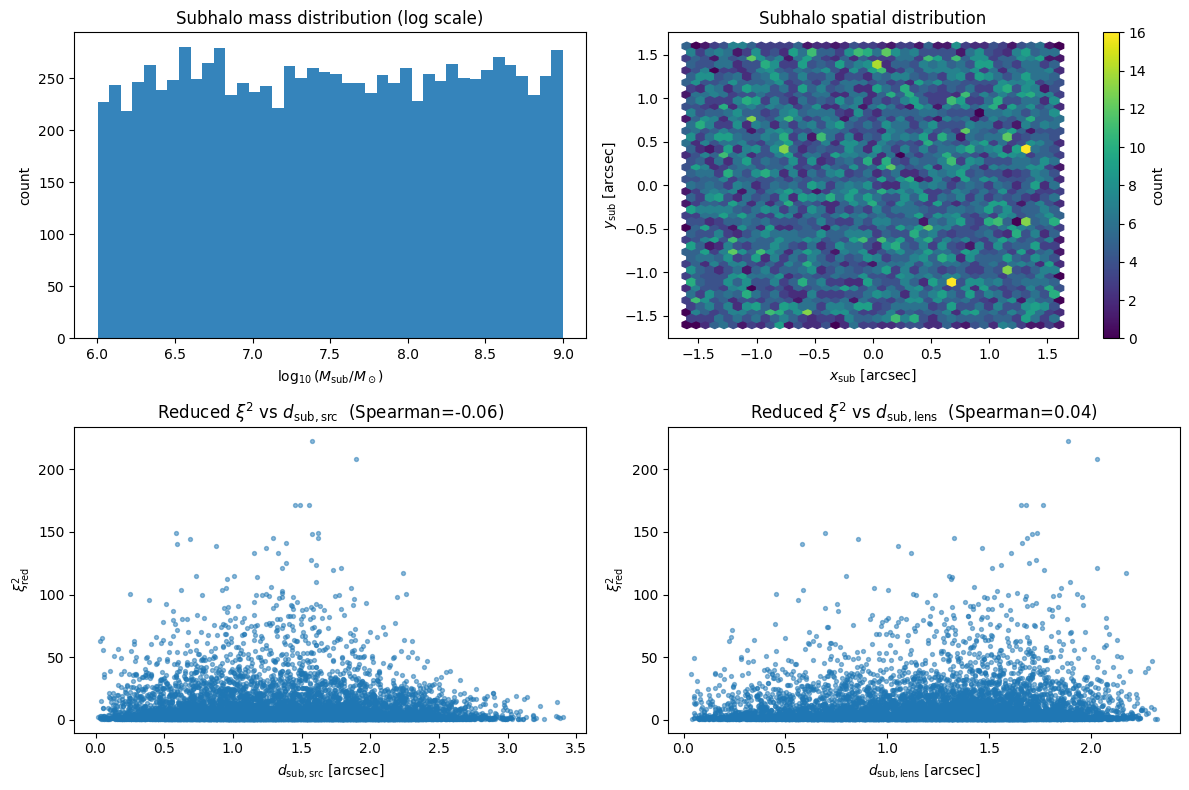

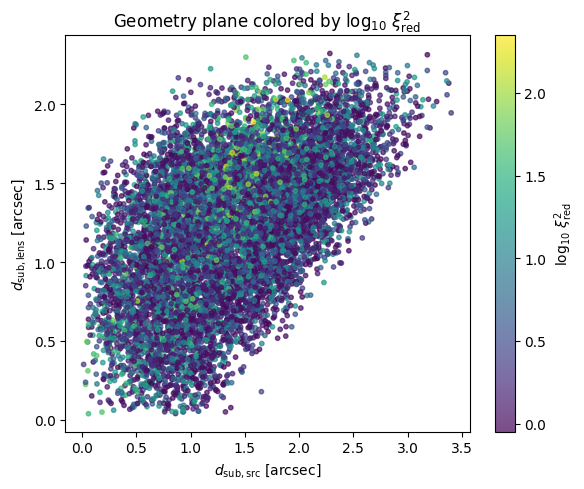

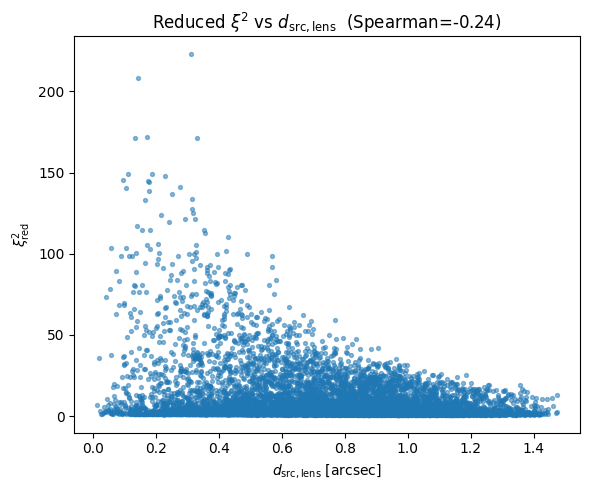

In [2]:
# ==== Cell 2: Mass/position distributions and geometry vs. reduced χ² ====
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

H5 = "LSST_singleband_dataset.h5"

def _pick_attr(attrs, name, default=None, cast=float):
    """Safe attribute getter with default and optional casting."""
    try:
        return cast(attrs[name])
    except Exception:
        return default

# ---------- Load scalars ----------
with h5py.File(H5, "r") as f:
    M   = f["subhalo_mass"][:]         # (N,) in Msun
    xs  = f["subhalo_x"][:]            # (N,) arcsec
    ys  = f["subhalo_y"][:]            # (N,) arcsec
    x0  = f["source_x"][:]             # (N,) arcsec
    y0  = f["source_y"][:]             # (N,) arcsec
    xi2r = f["xi2_reduced"][:]         # (N,) reduced chi-square

    # Lens center from attributes (fallback to the values used in generator)
    cx = _pick_attr(f.attrs, "lens_center_x", 0.0)
    cy = _pick_attr(f.attrs, "lens_center_y", -0.1)

# ---------- Derived geometric quantities ----------
# Distances (in arcsec)
d_sub_src  = np.hypot(xs - x0, ys - y0)   # subhalo–source
d_sub_lens = np.hypot(xs - cx, ys - cy)   # subhalo–lens center
d_src_lens = np.hypot(x0 - cx, y0 - cy)   # source–lens center

# Logs for plotting
logM  = np.log10(np.clip(M,    1e-30, None))
logXi = np.log10(np.clip(xi2r, 1e-12, None))

# ---------- Figure 1: Mass and position distributions ----------
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
ax11, ax12 = axs[0]
ax21, ax22 = axs[1]

# (1,1) Histogram of log10 subhalo mass
ax11.hist(logM, bins=40, alpha=.9)
ax11.set_xlabel(r'$\log_{10}(M_{\rm sub}/M_\odot)$')
ax11.set_ylabel('count')
ax11.set_title('Subhalo mass distribution (log scale)')

# (1,2) 2D hexbin of subhalo positions
hb = ax12.hexbin(xs, ys, gridsize=40, cmap='viridis')
ax12.set_xlabel(r'$x_{\rm sub}$ [arcsec]')
ax12.set_ylabel(r'$y_{\rm sub}$ [arcsec]')
ax12.set_title('Subhalo spatial distribution')
cb = plt.colorbar(hb, ax=ax12); cb.set_label('count')

# (2,1) Reduced χ² vs distance subhalo–source
rho, _ = spearmanr(d_sub_src, xi2r, nan_policy="omit")
ax21.scatter(d_sub_src, xi2r, s=8, alpha=.5)
ax21.set_xlabel(r'$d_{\rm sub,src}$ [arcsec]')
ax21.set_ylabel(r'$\xi^2_{\rm red}$')
ax21.set_title(f'Reduced $\\xi^2$ vs $d_{{\\rm sub,src}}$  (Spearman={rho:.2f})')

# (2,2) Reduced χ² vs distance subhalo–lens center
rho2, _ = spearmanr(d_sub_lens, xi2r, nan_policy="omit")
ax22.scatter(d_sub_lens, xi2r, s=8, alpha=.5)
ax22.set_xlabel(r'$d_{\rm sub,lens}$ [arcsec]')
ax22.set_ylabel(r'$\xi^2_{\rm red}$')
ax22.set_title(f'Reduced $\\xi^2$ vs $d_{{\\rm sub,lens}}$  (Spearman={rho2:.2f})')

plt.tight_layout()
plt.show()

# ---------- Figure 2: Geometry plane colored by log10 reduced χ² ----------
fig, ax = plt.subplots(figsize=(6, 5))
sc = ax.scatter(d_sub_src, d_sub_lens, c=logXi, s=10, alpha=.7)
ax.set_xlabel(r'$d_{\rm sub,src}$ [arcsec]')
ax.set_ylabel(r'$d_{\rm sub,lens}$ [arcsec]')
ax.set_title(r'Geometry plane colored by $\log_{10}\,\xi^2_{\rm red}$')
cb = plt.colorbar(sc, ax=ax); cb.set_label(r'$\log_{10}\,\xi^2_{\rm red}$')
plt.tight_layout()
plt.show()

# ---------- Figure 3: Reduced χ² vs source–lens distance ----------
fig, ax = plt.subplots(figsize=(6, 5))
rho3, _ = spearmanr(d_src_lens, xi2r, nan_policy="omit")
ax.scatter(d_src_lens, xi2r, s=8, alpha=.5)
ax.set_xlabel(r'$d_{\rm src,lens}$ [arcsec]')
ax.set_ylabel(r'$\xi^2_{\rm red}$')
ax.set_title(f'Reduced $\\xi^2$ vs $d_{{\\rm src,lens}}$  (Spearman={rho3:.2f})')
plt.tight_layout()
plt.show()


### Classification

## DataLoader for Single-band LSST Lensing Dataset

This cell defines a **lightweight PyTorch DataLoader** for the single-band LSST lensing dataset, focusing on the regression of the *reduced chi-squared* (ξ²<sub>red</sub>) statistic from simulated noisy images.

---

### **Purpose**
The goal is to load pairs **(X, Y)** where:
- **X** → the *noisy image* containing the subhalo (`image_sub`).
- **Y** → the *reduced chi-squared statistic* (`xi2_reduced`), used as the regression target.

---

### **Key features**
- Reads data directly from the HDF5 file `LSST_singleband_dataset.h5`.
- Converts images into PyTorch tensors of shape **(1, H, W)**.
- Applies a **logarithmic transform** to the target variable:
  $$
  y = \log_{10}(\xi^2_{\text{red}} + 10^{-3})
  $$
  This reduces the dynamic range of ξ²<sub>red</sub>, improving numerical stability during training.
- Includes reproducible **train/validation/test splits** (70% / 15% / 15%).
- Automatically constructs `DataLoader` objects for CUDA-enabled training.

---

### **Structure**
| Component | Description |
|:-----------|:-------------|
| `Xi2RedDataset` | Custom `torch.utils.data.Dataset` subclass for HDF5 access. |
| `build_dataloaders()` | Creates datasets and DataLoaders with consistent splits and metadata. |
| `__getitem__()` | Returns a dict with `x`, `y`, and `idx` keys for training loops. |

---

### **Output Example**
Upon running as a script (`__main__` section), it prints:


In [3]:
# xi2reduced_dataloader_singleband_min.py
# --------------------------------------
# Minimal DataLoader for single-band LSST lensing dataset
# Inputs: noisy images with subhalo ("image_sub")
# Targets: reduced chi-square values ("xi2_reduced"), log-transformed

import h5py, numpy as np, torch
from torch.utils.data import Dataset, DataLoader

# === Global configuration ===
H5_PATH     = "LSST_singleband_dataset.h5"
BATCH_SIZE  = 32
NUM_WORKERS = 2
SEED        = 123

# Dataset keys
IMG_KEY    = "image_sub"     # X = noisy image including subhalo
TARGET_KEY = "xi2_reduced"   # Y = reduced χ² (target)

# ===========================================================
# Custom Dataset for reduced χ² regression
# ===========================================================
class Xi2RedDataset(Dataset):
    def __init__(self, h5_path, indices, y_scale=1.0):
        """
        Minimal dataset wrapper for LSST single-band simulations.

        Args:
            h5_path (str): Path to HDF5 dataset file.
            indices (array): Indices for train/val/test split.
            y_scale (float): Optional global scaling constant (not used if log transform is applied).
        """
        self.f       = h5py.File(h5_path, "r")
        self.X       = self.f[IMG_KEY]                # (N,H,W) or (N,H,W,1)
        self.y_raw   = self.f[TARGET_KEY][:].astype("f4")  # (N,)
        self.idxs    = np.asarray(indices)
        self.y_scale = float(y_scale) if y_scale > 0 else 1.0

        # Define how to extract image samples consistently as (1,H,W)
        sample = self.X[0]
        if sample.ndim == 2:
            # (H,W) → (1,H,W)
            self._get_item = lambda i: self.X[i][None, ...].astype("f4")
        elif sample.ndim == 3:
            # (H,W,1) → (1,H,W) or keep (C,H,W) if multiple channels
            def _getter(i):
                arr = self.X[i].astype("f4")
                if arr.shape[-1] == 1:
                    return np.transpose(arr, (2, 0, 1))
                else:
                    return np.transpose(arr, (2, 0, 1))
            self._get_item = _getter
        else:
            raise ValueError("image_sub must have shape (N,H,W) or (N,H,W,1).")

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, k):
        """
        Returns a single training sample:
            x: torch.FloatTensor of shape (1,H,W)
            y: log-transformed reduced χ² (1,)
        """
        i = int(self.idxs[k])
        x = self._get_item(i)
        # Apply logarithmic transformation for target stability
        # (log10 helps reduce the dynamic range of χ²_red)
        y = np.array([ np.log10(self.y_raw[i] + 1e-3) ], dtype="f4")
        return {"x": torch.from_numpy(x), "y": torch.from_numpy(y), "idx": i}

# ===========================================================
# Build DataLoaders for training, validation, and testing
# ===========================================================
def build_dataloaders(h5_path=H5_PATH, batch_size=BATCH_SIZE,
                      num_workers=NUM_WORKERS, seed=SEED):
    """
    Creates train/validation/test DataLoaders from the HDF5 dataset.
    """
    rng = np.random.default_rng(seed)
    with h5py.File(h5_path, "r") as f:
        X = f[IMG_KEY]
        N = X.shape[0]
        y_raw = f[TARGET_KEY][:].astype("f8")
        y_max = float(np.max(y_raw))  # global max for reference

    # Reproducible random split (70/15/15)
    idx = np.arange(N); rng.shuffle(idx)
    n_tr = int(0.70 * N); n_va = int(0.15 * N)
    idx_tr = idx[:n_tr]
    idx_va = idx[n_tr:n_tr + n_va]
    idx_te = idx[n_tr + n_va:]

    # Instantiate datasets
    ds_tr = Xi2RedDataset(h5_path, idx_tr, y_scale=y_max)
    ds_va = Xi2RedDataset(h5_path, idx_va, y_scale=y_max)
    ds_te = Xi2RedDataset(h5_path, idx_te, y_scale=y_max)

    # Create DataLoaders
    dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=True)
    dl_va = DataLoader(ds_va, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    dl_te = DataLoader(ds_te, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    # Metadata summary
    meta = {
        "N": N,
        "train/val/test": (len(idx_tr), len(idx_va), len(idx_te)),
        "img_key": IMG_KEY,
        "y_scale": y_max,
        "target_key": TARGET_KEY
    }
    print("[meta]", meta)
    return dl_tr, dl_va, dl_te, meta

# ===========================================================
# Quick sanity check (standalone run)
# ===========================================================
if __name__ == "__main__":
    dl_tr, dl_va, dl_te, meta = build_dataloaders()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    b = next(iter(dl_tr))
    print("device =", device)
    print("batch x:", b["x"].shape, b["x"].dtype, "on", device)
    print("batch y:", b["y"].shape, b["y"].min().item(), b["y"].max().item())


[meta] {'N': 10000, 'train/val/test': (7000, 1500, 1500), 'img_key': 'image_sub', 'y_scale': 222.94724215451635, 'target_key': 'xi2_reduced'}
device = cuda
batch x: torch.Size([32, 1, 30, 30]) torch.float32 on cuda
batch y: torch.Size([32, 1]) 0.006422759965062141 1.6464585065841675


This diagnostic cell verifies that the **reduced χ² values** (ξ²<sub>red</sub>) and corresponding **noisy subhalo images** have been correctly loaded by the DataLoader.

---

### **1. Target distribution check**
For each split (train / validation / test), the code:
- Collects all target values (`y`) from the DataLoaders.
- Prints their **minimum, maximum, mean, and standard deviation**.
- Displays histograms of  
  $$
  \log_{10}\big(\xi^2_{\text{red}} + 10^{-3}\big)
  $$
  to visualize the distribution and confirm that the log-scaling compresses the dynamic range.

This helps ensure that:
- The train/val/test splits have consistent value ranges.
- There are no NaNs or outliers that could destabilize training.

---

### **2. Visual check of a sample input image**
The second part displays a random example from the **training set**:
- The image (`X`) corresponds to a **noisy lensed system including a subhalo**.
- The title shows the **log-scaled reduced χ²** associated with that image.

The color scale uses the `inferno` colormap for better contrast of lensing features.

---

### **Why this check matters**
Before training the CNN regressor, this step confirms that:
- The data pipeline correctly reads and scales both inputs and targets.
- The ξ²<sub>red</sub> distribution is suitable for regression (roughly continuous and finite).
- The visual appearance of input images matches expectations from the generator.

---

[train] xi2_reduced (log-scaled): min=-0.0486, max=2.3187, mean=0.5526, std=0.5216
[val]   xi2_reduced (log-scaled): min=-0.0357, max=2.0981, mean=0.5300
[test]  xi2_reduced (log-scaled): min=-0.0262, max=2.3482, mean=0.5328


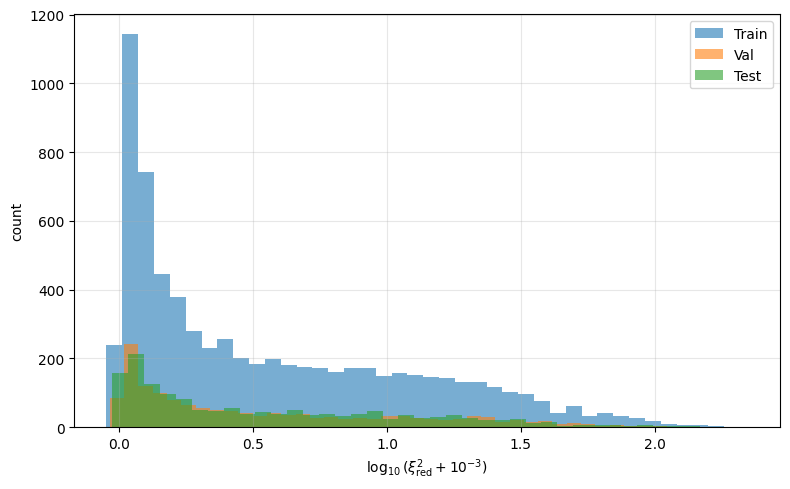

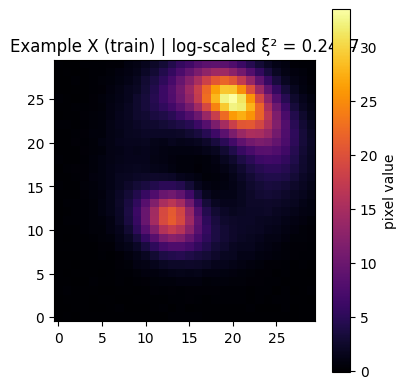

In [4]:
# === sanity check: visualize xi2_reduced distribution and a sample image ===

# Make sure the dataloaders have been built:
# dl_tr, dl_va, dl_te, meta = build_dataloaders()

# ------------------------------------------------------------
# Helper function: gather all target values from a DataLoader
# ------------------------------------------------------------
def collect_targets(dloader):
    """Concatenate all target tensors (y) from a DataLoader into a single numpy array."""
    all_y = []
    for batch in dloader:
        y = batch["y"].numpy().flatten()
        all_y.append(y)
    return np.concatenate(all_y, axis=0)

# Collect targets from train, validation, and test splits
y_tr = collect_targets(dl_tr)
y_va = collect_targets(dl_va)
y_te = collect_targets(dl_te)

# Print basic statistics of the target distributions
print(f"[train] xi2_reduced (log-scaled): min={y_tr.min():.4f}, max={y_tr.max():.4f}, mean={y_tr.mean():.4f}, std={y_tr.std():.4f}")
print(f"[val]   xi2_reduced (log-scaled): min={y_va.min():.4f}, max={y_va.max():.4f}, mean={y_va.mean():.4f}")
print(f"[test]  xi2_reduced (log-scaled): min={y_te.min():.4f}, max={y_te.max():.4f}, mean={y_te.mean():.4f}")

# ------------------------------------------------------------
# Histograms of the target distributions across splits
# ------------------------------------------------------------
plt.figure(figsize=(8,5))
plt.hist(y_tr, bins=40, alpha=0.6, label='Train', color='tab:blue')
plt.hist(y_va, bins=40, alpha=0.6, label='Val', color='tab:orange')
plt.hist(y_te, bins=40, alpha=0.6, label='Test', color='tab:green')
plt.xlabel(r'$\log_{10}(\xi^2_{\mathrm{red}} + 10^{-3})$')
plt.ylabel("count")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Visualize one example image from the training set
# ------------------------------------------------------------
batch = next(iter(dl_tr))
x = batch["x"][0, 0].numpy()   # (1,H,W) -> (H,W)
y = batch["y"][0].item()

plt.figure(figsize=(4,4))
plt.imshow(x, origin='lower', cmap='inferno')
plt.colorbar(label='pixel value')
plt.title(f"Example X (train) | log-scaled ξ² = {y:.4f}")
plt.tight_layout()
plt.show()


## Training: single-band regression of reduced ξ² (log-space)

**Goal.** Train a small CNN to predict the **reduced χ²** (ξ²\_red) from the **noisy subhalo image**.  
We regress in **log space** using the target:
$$
y = \log_{10}\!\big(\xi^2_{\mathrm{red}} + \varepsilon\big), \quad \varepsilon=10^{-3}.
$$
This stabilizes the loss and compresses the heavy-tailed distribution.

---

### Model
- 3× Conv2d (3×3, padding=1) with **tanh** activations, each followed by **AvgPool2d(2)**.  
- A small MLP head produces a single scalar output (**log-space ξ²\_red**).

### Optimization
- **Adam** (fixed LR = 1e-3), **MSE loss in log-space**.
- We track training/validation MSE and **save the best** model by val MSE.

### Plots and Metrics
- **Loss curve:** Training/validation MSE in log space across epochs.
- **Test metrics:**
  - Log-space: MSE, MAE on $ \log_{10}(\xi^2_{\mathrm{red}}+\varepsilon) $
  - Physical units: convert back via $ \hat{\xi}^2_{\mathrm{red}}=\max(10^{\hat{y}}-\varepsilon,\,0) $

---

### Notes
- The constant $ \varepsilon=10^{-3} $ must match the dataloader’s transform.
- Using log space prevents large residuals from dominating the loss due to the long tail of ξ²\_red.
- If you later normalize inputs (images) further, keep that consistent across train/val/test.


/home/kingsman/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[meta] {'N': 10000, 'train/val/test': (7000, 1500, 1500), 'img_key': 'image_sub', 'y_scale': 222.94724215451635, 'target_key': 'xi2_reduced'}


train xi2_reduced (tanh, fixed LR): 100%|██████████| 100/100 [1:23:42<00:00, 50.22s/it, tr_mse(log)=0.04054, va_mse(log)=0.03947, lr=0.001]


[done] best val MSE (log-space) = 0.0339654  -> best_xi2red_regressor_tanh.pt


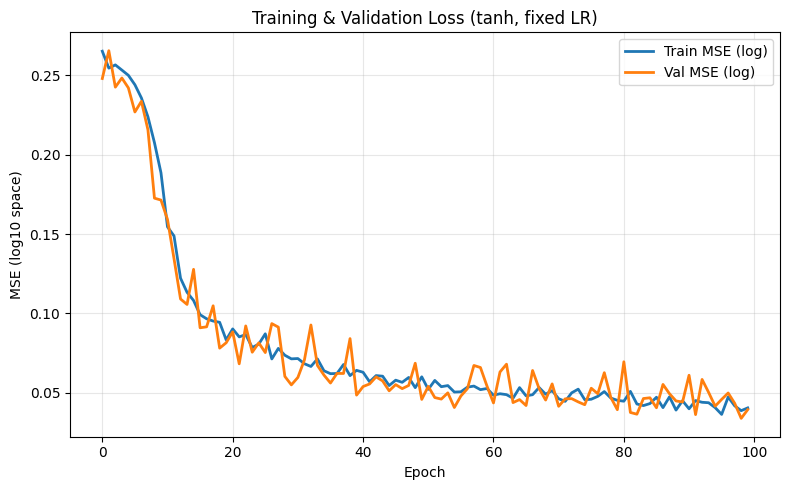

[test metrics] log-space: {'mse_log': 0.035646108945210773, 'mae_log': 0.1449726085662842}
[test metrics] physical : {'mse_phys': 87.65036305745443, 'mae_phys': 3.014865872701009}


In [5]:
# === xi2_reduced regression (single-band) — fixed LR + tanh + loss curve ===
import math, torch, torch.nn as nn, torch.nn.functional as F
# from torch.utils.data import DataLoader
from tqdm.auto import trange

# Assumes your dataloader returns y = log10(xi2_reduced + EPS_Y)
# from xi2reduced_dataloader_singleband_min.py (or equivalent)
dl_tr, dl_va, dl_te, meta = build_dataloaders()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Must match the constant used in the dataloader transform
EPS_Y = 1e-3

# -----------------------------
# Model: small CNN with tanh activations
# -----------------------------
class TinyRegressor(nn.Module):
    def __init__(self, in_ch=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16,   32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32,   64, kernel_size=3, padding=1)
        self.pool  = nn.AvgPool2d(2)  # spatial downsampling by 2

        # After 3 pools, feature map is H/8 x W/8
        H = dl_tr.dataset.X.shape[1]
        W = dl_tr.dataset.X.shape[2]
        h8, w8 = H // 8, W // 8

        self.head  = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * h8 * w8, 128),
            nn.Tanh(),
            nn.Linear(128, 1)  # 1D regression in log-space
        )

    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = self.pool(x)             # /2
        x = torch.tanh(self.conv2(x))
        x = self.pool(x)             # /4
        x = torch.tanh(self.conv3(x))
        x = self.pool(x)             # /8
        return self.head(x)

model = TinyRegressor(in_ch=dl_tr.dataset[0]["x"].shape[0]).to(device)
torch.backends.cudnn.benchmark = True

# -----------------------------
# Optimizer / loss (fixed LR, simple MSE in log-space)
# -----------------------------
epochs = 100
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion  = nn.MSELoss()

# Track losses per epoch
train_losses, val_losses = [], []

def run_epoch(dloader, train=True):
    """One epoch over a dataloader; returns average loss."""
    model.train(train)
    running, n = 0.0, 0
    for batch in dloader:
        x = batch["x"].to(device, non_blocking=True).float()   # (B,1,H,W)
        y = batch["y"].to(device, non_blocking=True).float()   # (B,1), log10(xi2_red + EPS_Y)

        if train:
            optimizer.zero_grad(set_to_none=True)
            y_hat = model(x)
            loss  = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
        else:
            with torch.no_grad():
                y_hat = model(x)
                loss  = criterion(y_hat, y)

        bs = x.size(0)
        running += loss.item() * bs
        n += bs
    return running / max(n, 1)

# -----------------------------
# Training loop: save best by validation MSE (log-space)
# -----------------------------
best_val = math.inf
ckpt_path = "best_xi2red_regressor_tanh.pt"
pbar = trange(epochs, desc="train xi2_reduced (tanh, fixed LR)")
for ep in pbar:
    tr_loss = run_epoch(dl_tr, train=True)
    va_loss = run_epoch(dl_va, train=False)
    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    pbar.set_postfix({"tr_mse(log)": f"{tr_loss:.4g}", "va_mse(log)": f"{va_loss:.4g}", "lr": lr})

    if va_loss < best_val:
        best_val = va_loss
        torch.save({"model": model.state_dict(), "meta": meta, "epoch": ep, "val_mse_log": va_loss}, ckpt_path)

print(f"[done] best val MSE (log-space) = {best_val:.6g}  -> {ckpt_path}")

# -----------------------------
# Loss curve
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train MSE (log)", lw=2)
plt.plot(val_losses,   label="Val MSE (log)", lw=2)
plt.xlabel("Epoch"); plt.ylabel("MSE (log10 space)")
plt.title("Training & Validation Loss (tanh, fixed LR)")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
plt.savefig("loss_curve_xi2reduced_tanh.png", dpi=120)
plt.show()

# -----------------------------
# Test evaluation: log-space and physical units
# -----------------------------
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt["model"]); model.eval()

def inv_log_transform(y_log: torch.Tensor) -> torch.Tensor:
    """Inverse transform to physical reduced ξ²: 10**y_log - EPS_Y, clamped to >= 0."""
    return torch.clamp(10.0**y_log - EPS_Y, min=0.0)

@torch.no_grad()
def eval_metrics(dloader):
    se_log, ae_log, n = 0.0, 0.0, 0
    se_phy, ae_phy = 0.0, 0.0
    for batch in dloader:
        x = batch["x"].to(device).float()
        y_log = batch["y"].to(device).float()            # log10(xi2_red + EPS_Y)
        yhat_log = model(x)

        # Log-space metrics
        diff_log = yhat_log - y_log
        se_log += torch.sum(diff_log**2).item()
        ae_log += torch.sum(torch.abs(diff_log)).item()

        # Physical units
        y_phy    = inv_log_transform(y_log)
        yhat_phy = inv_log_transform(yhat_log)
        se_phy  += torch.sum((yhat_phy - y_phy)**2).item()
        ae_phy  += torch.sum(torch.abs(yhat_phy - y_phy)).item()
        n += y_log.numel()

    return {
        "mse_log":  se_log / n,
        "mae_log":  ae_log / n,
        "mse_phys": se_phy / n,
        "mae_phys": ae_phy / n,
    }

metrics_te = eval_metrics(dl_te)
print("[test metrics] log-space:", {k:v for k,v in metrics_te.items() if "log"  in k})
print("[test metrics] physical :", {k:v for k,v in metrics_te.items() if "phys" in k})


## Diagnostics: predicted vs true reduced ξ²

**Setup.** The model was trained to predict  
$$
y = \log_{10}\!\big(\xi^2_{\rm red} + \varepsilon\big), \quad \varepsilon=10^{-3}.
$$
This cell compares predictions to ground truth in **log-space** (the training space) and in **physical units** (reduced ξ²), applying the inverse transform:
$$
\widehat{\xi}^2_{\rm red} = \max\!\big(10^{\hat{y}} - \varepsilon,\,0\big).
$$

### What you’ll see
1. **Scatter (log-space):** Predicted vs true $$\log_{10}(\xi^2_{\rm red}+\varepsilon)$$.  
   The closer to the diagonal, the better.
2. **Scatter (physical units):** Predicted vs true $$\xi^2_{\rm red}$$ after inverse transform.  
3. **Residual histograms:** Error distributions in both spaces.
4. **Metrics:** MSE/MAE in log-space and in physical units, plus $$R^2$$ in each.

**Why evaluate in both spaces?**  
- Log-space reflects the actual training objective and is more stable with heavy tails.  
- Physical units show practical performance for scientific interpretation (e.g., typical under/overestimation of reduced ξ²).


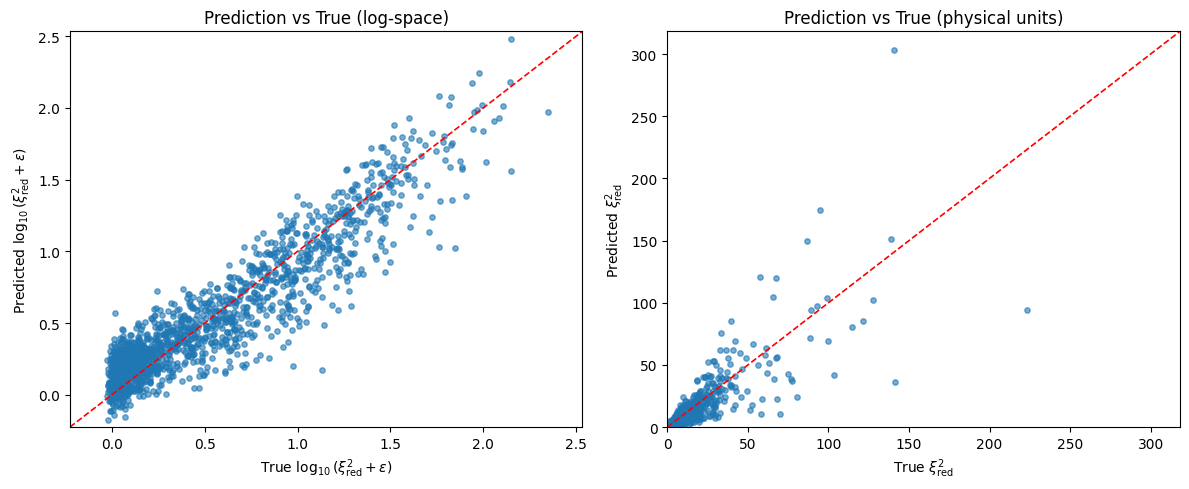

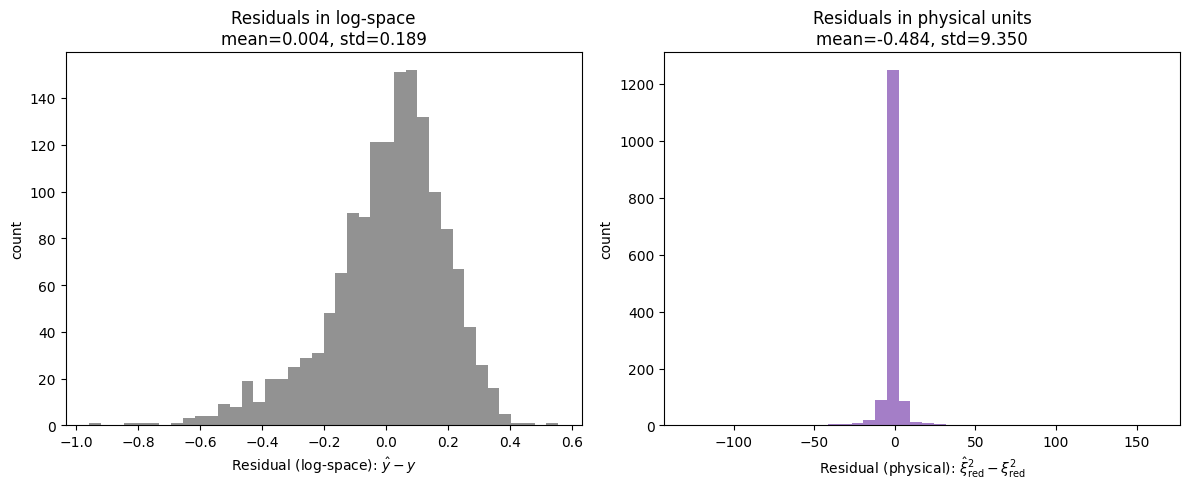

=== Test Metrics ===
Log-space -> MSE=0.03565, MAE=0.14497, R²=0.8616
Physical  -> MSE=8.765e+01, MAE=3.015e+00, R²=0.6478


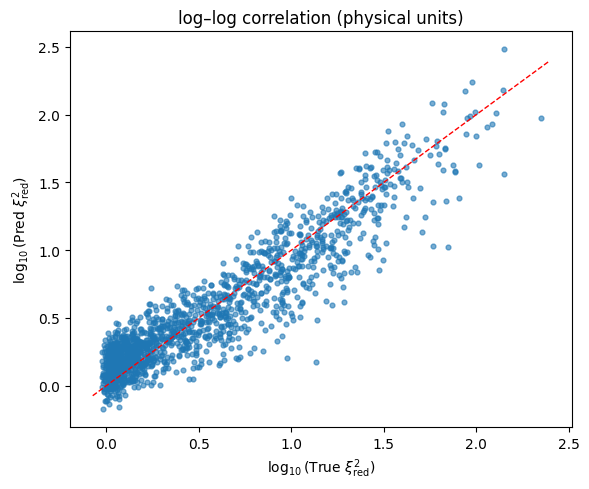

In [7]:
# === Diagnostics: predicted vs true xi2_reduced (log-aware) ===
import matplotlib.pyplot as plt
import numpy as np
import torch

# Must match the EPS used in your dataloader (Xi2RedDataset)
EPS_Y = 1e-3

def inv_log_transform(y_log: np.ndarray, eps=EPS_Y) -> np.ndarray:
    """Inverse transform: log10(x + eps) -> x in physical units."""
    return np.clip(10.0**y_log - eps, a_min=0.0, a_max=None)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

y_true_log, y_pred_log = [], []

with torch.no_grad():
    for batch in dl_te:
        x = batch["x"].to(device).float()
        y = batch["y"].to(device).float()        # y = log10(xi2_reduced + EPS_Y)
        y_hat = model(x)                         # prediction in log space
        y_true_log.append(y.cpu().numpy())
        y_pred_log.append(y_hat.cpu().numpy())

# Concatenate all test samples
y_true_log = np.concatenate(y_true_log).ravel()
y_pred_log = np.concatenate(y_pred_log).ravel()

# Convert to physical reduced-ξ² (undo log and subtract EPS)
y_true_phys = inv_log_transform(y_true_log, eps=EPS_Y)
y_pred_phys = inv_log_transform(y_pred_log, eps=EPS_Y)

# =======================
# 1) Scatter: log-space (what the model actually optimizes)
# =======================
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

ax = axs[0]
ax.scatter(y_true_log, y_pred_log, s=15, alpha=0.6)
lims = [min(y_true_log.min(), y_pred_log.min()), max(y_true_log.max(), y_pred_log.max())]
pad = 0.02 * (lims[1] - lims[0])
lims = [lims[0]-pad, lims[1]+pad]
ax.plot(lims, lims, 'r--', lw=1.2)
ax.set_xlabel(r"True $\log_{10}(\xi^2_{\rm red}+\varepsilon)$")
ax.set_ylabel(r"Predicted $\log_{10}(\xi^2_{\rm red}+\varepsilon)$")
ax.set_title("Prediction vs True (log-space)")
ax.set_xlim(lims); ax.set_ylim(lims)

# =======================
# 2) Scatter: physical units (reduced ξ²)
# =======================
ax = axs[1]
ax.scatter(y_true_phys, y_pred_phys, s=15, alpha=0.6, color="tab:blue")
lims = [0.0, max(y_true_phys.max(), y_pred_phys.max()) * 1.05]
ax.plot(lims, lims, 'r--', lw=1.2)
ax.set_xlabel(r"True $\xi^2_{\rm red}$")
ax.set_ylabel(r"Predicted $\xi^2_{\rm red}$")
ax.set_title("Prediction vs True (physical units)")
ax.set_xlim(lims); ax.set_ylim(lims)

plt.tight_layout()
plt.show()

# =======================
# 3) Residual analysis (log-space and physical)
# =======================
resid_log  = y_pred_log - y_true_log
resid_phys = y_pred_phys - y_true_phys

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].hist(resid_log, bins=40, color='tab:gray', alpha=0.85)
axs[0].set_xlabel(r"Residual (log-space): $\hat{y}-y$")
axs[0].set_ylabel("count")
axs[0].set_title(f"Residuals in log-space\nmean={resid_log.mean():.3f}, std={resid_log.std():.3f}")

axs[1].hist(resid_phys, bins=40, color='tab:purple', alpha=0.85)
axs[1].set_xlabel(r"Residual (physical): $\hat{\xi}^2_{\rm red}-\xi^2_{\rm red}$")
axs[1].set_ylabel("count")
axs[1].set_title(f"Residuals in physical units\nmean={resid_phys.mean():.3f}, std={resid_phys.std():.3f}")

plt.tight_layout()
plt.show()

# =======================
# 4) Metrics summary
# =======================
def r2_score(y_true, y_pred):
    denom = np.sum((y_true - np.mean(y_true))**2)
    num   = np.sum((y_true - y_pred)**2)
    return 1.0 - (num / denom if denom > 0 else np.nan)

mse_log = np.mean((y_true_log - y_pred_log)**2)
mae_log = np.mean(np.abs(y_true_log - y_pred_log))
r2_log  = r2_score(y_true_log, y_pred_log)

mse_p = np.mean((y_true_phys - y_pred_phys)**2)
mae_p = np.mean(np.abs(y_true_phys - y_pred_phys))
r2_p  = r2_score(y_true_phys, y_pred_phys)

print("=== Test Metrics ===")
print(f"Log-space -> MSE={mse_log:.5f}, MAE={mae_log:.5f}, R²={r2_log:.4f}")
print(f"Physical  -> MSE={mse_p:.3e}, MAE={mae_p:.3e}, R²={r2_p:.4f}")

# Optional: log–log correlation in physical space (helps with wide dynamic ranges)
plt.figure(figsize=(6,5))
plt.scatter(np.log10(y_true_phys + 1e-12), np.log10(y_pred_phys + 1e-12), s=12, alpha=0.6)
lims = [np.log10((y_true_phys + 1e-12).min()), np.log10((y_true_phys + 1e-12).max())]
pad = 0.02 * (lims[1] - lims[0])
lims = [lims[0]-pad, lims[1]+pad]
plt.plot(lims, lims, 'r--', lw=1)
plt.xlabel(r"$\log_{10}(\mathrm{True}\ \xi^2_{\rm red})$")
plt.ylabel(r"$\log_{10}(\mathrm{Pred}\ \xi^2_{\rm red})$")
plt.title("log–log correlation (physical units)")
plt.tight_layout()
plt.show()
